In [1]:
# Bloc 1

import os
from datetime import datetime

import numpy as np
import pandas as pd

import librosa
import librosa.display 

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

2024-12-01 18:55:15.052928: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 18:55:15.478125: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-01 18:55:15.478139: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-01 18:55:16.957285: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [2]:
target_sr = 16000

def parse_time(time_str):
    dt = datetime.strptime(time_str, "%Y-%m-%d_%H-%M-%S-%f")
    # Convert to total seconds since the start of the day
    total_seconds = dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6
    return dt, total_seconds  # Return both datetime object and total seconds

def segment_audio(file_path, label_file):
    y, sr = librosa.load(file_path, sr=None)
    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    with open(label_file, 'r') as f:
        lines = f.readlines()
    
    labels = []
    for line in lines[1:]:
        if(" | " not in line):
            continue
        time_str, position = line.strip().split(' | ')
        dt, total_seconds = parse_time(time_str)
        labels.append([dt, total_seconds, float(position)])
    labels = np.array(labels)
    
    times = labels[:, 1]  # Total seconds since midnight
    dates = labels[:, 0]  # Datetime objects
    positions = labels[:, 2]  # Positions
    
    segments_with_speed = []
    cursor = 0  # Start at the beginning of the audio file
    
    deltaTime = 1
    imax = len(times) - 1
    while(imax % deltaTime != 0 ):
        imax = imax - 1
    for i in range(0, imax, deltaTime):
        start_time = times[i]
        end_time = times[i + deltaTime]
        start_date = dates[i]
        end_date = dates[i + deltaTime]
        
        # Check for day change
        if end_date.date() > start_date.date():
            segment_length = (86400 - start_time) + end_time  # 86400 seconds in a day
        else:
            segment_length = end_time - start_time
        
        end_sample = cursor + int(segment_length * target_sr)
        
        if cursor >= end_sample or segment_length < 0.1:
            print(f"Warning: Empty or realy small segment detected. Cursor: {cursor}, End: {end_sample}")
            continue
        
        segment = y[cursor:end_sample]
        speed = (positions[i+deltaTime] - positions[i]) / segment_length
        
        #Text file longer than audio file trigger this or sometime last segment is too small
        if(len(segment) == 0 or segment.shape[0] < deltaTime * 1740):
            continue

        segments_with_speed.append((segment, speed))
        
        cursor = end_sample  # Move cursor to the start of the next segment
    
    return segments_with_speed

def extract_audio_features(segments):
    features = []
    for segment in segments:
        # Convert to mono if necessary
        if segment.ndim > 1:
            segment = librosa.to_mono(segment)
        

        mfccs = librosa.feature.mfcc(y=segment, sr=target_sr, n_mfcc=13, n_fft=1024)
        #print(mfccs.shape)
        mfcc_mean = np.mean(mfccs, axis=1)
        #print(mfcc_mean.shape)

        #spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=target_sr, n_fft=1024)    
        #print(spectral_centroid)
        #spectral_centroid_mean = np.mean(spectral_centroid, axis=1)
        #print(spectral_centroid_mean.shape)

        #rms = librosa.feature.rms(y=segment)
        #rms_mean = np.mean(rms, axis=1)
        #print(rms_mean.shape)

        #mel_spec = librosa.feature.melspectrogram(y=segment, sr=target_sr, n_fft=1024)
        #mel_spec_mean = np.mean(mel_spec, axis=1)
        #print(mel_spec_mean.shape)

        # Combine features for this segment
        segment_features = np.hstack((mfcc_mean)) #,spectral_centroid_mean,rms_mean,mel_spec_mean,
        features.append(segment_features)

    #Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    return np.array(normalized_features)

def normalize_speed(speeds):
    """
    Normalize speeds where 0 speed is 0 and 150 inch-minutes is 1.
    
    :param speeds: List or array of speeds in inch-minutes
    :return: Normalized speeds between 0 and 1
    """
    max_speed = max(speeds)  # Maximum speed in your dataset
    min_speed = 0    # Minimum speed in your dataset
    
    # Ensure speeds are numpy array for vectorized operations
    speeds = np.array(speeds)
    
    # Normalize speeds
    normalized_speeds = np.clip(speeds / max_speed, 0, 1)
    
    return normalized_speeds

In [3]:
directory = "../DataSP1/"
segments_and_speed = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the file is a .wav file
    if filename.endswith(".wav"):
        # Construct the full file path
        filepath = os.path.join(directory, filename)
        segments_and_speed.extend(segment_audio(filepath, filepath[:-3] + "txt"))

In [4]:
segments, speeds = zip(*segments_and_speed)
#truncate the segments so that they all have the same shape
min_len = min(len(segment) for segment in segments)
print(min_len)
truncated_segments = [segment[:min_len] for segment in segments]

npSegments = np.vstack(truncated_segments)
# Calculate the absolute maximum value across all segments
max_val = np.max(np.abs(npSegments))

# Normalize by dividing by the maximum value
normalized_segments = npSegments / max_val

#Extract features
normalized_audio_features = extract_audio_features(normalized_segments)
normalized_audio_features = np.squeeze(normalized_audio_features)

#Apply PCA to keep only the best features
#pca = PCA(n_components=0.90)
#pca_features = pca.fit_transform(normalized_audio_features)

# You can check how many components were actually used
#n_components = pca.n_components_
#print(f"Number of components to explain 90% variance: {n_components} out of {normalized_audio_features.shape[1]}")

# Convert speeds to numpy array for consistency with features
speeds = np.array(speeds)

#normalize speed
normalized_speeds = normalize_speed(speeds)

# Ensure features and labels are aligned
#assert len(audio_features) == len(normalized_speeds), "Mismatch in feature and label counts"

X_train, X_test, y_train, y_test = train_test_split(normalized_audio_features, normalized_speeds, test_size=0.2, random_state=42)


1743


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

model = MLPModel(input_size=X_train.shape[1])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10 
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

model.eval()
y_pred = model(X_test_tensor).detach().numpy()


Epoch 1/10, Loss: 0.00012855177919846028
Epoch 2/10, Loss: 0.0003136895829811692
Epoch 3/10, Loss: 8.276991866296157e-05
Epoch 4/10, Loss: 0.00017867115093395114
Epoch 5/10, Loss: 0.002060291590169072
Epoch 6/10, Loss: 0.010065975598990917
Epoch 7/10, Loss: 0.00048145625623874366
Epoch 8/10, Loss: 0.00018523429753258824
Epoch 9/10, Loss: 0.0017138620605692267
Epoch 10/10, Loss: 0.028681566938757896


In [6]:
# Bloc 7

from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
y_pred = model(X_test_tensor).detach().numpy().squeeze()  # Convertir les prédictions en numpy array

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")
print(f"Mean Absolute Error (MAE): {mae:.10f}")
print(f'R-squared Score: {r2}')


Mean Squared Error (MSE): 0.0042387142
Root Mean Squared Error (RMSE): 0.0651054084
Mean Absolute Error (MAE): 0.0210664409
R-squared Score: 0.9420684692670168


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


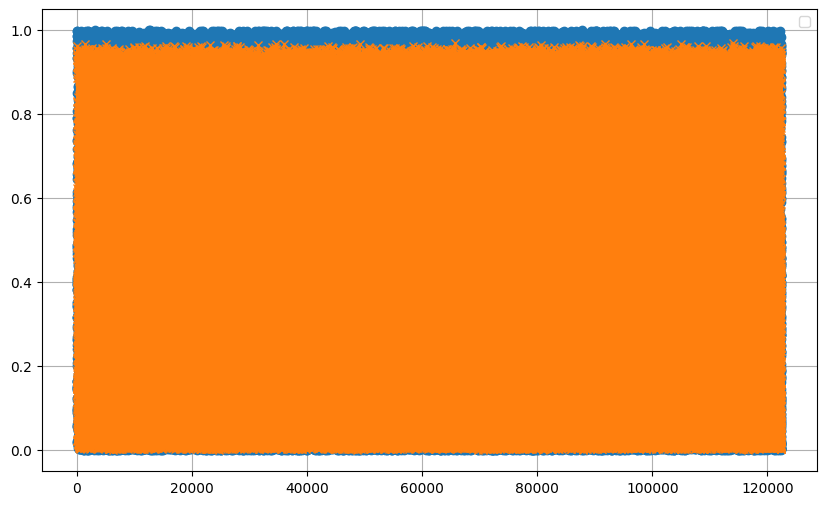

In [7]:
# Bloc 8

plt.figure(figsize=(10, 6))
plt.plot(y_test, marker='o')
plt.plot(y_pred, marker='x')
plt.legend()
plt.grid()
plt.show()


Mean Absolute Error: 0.02106644088670884
Mean Squared Error: 0.004238714201355106
Root Mean Squared Error: 0.06510540838789898
R-squared Score: 0.9420684692670168
Median Absolute Error: 0.009447174714643639


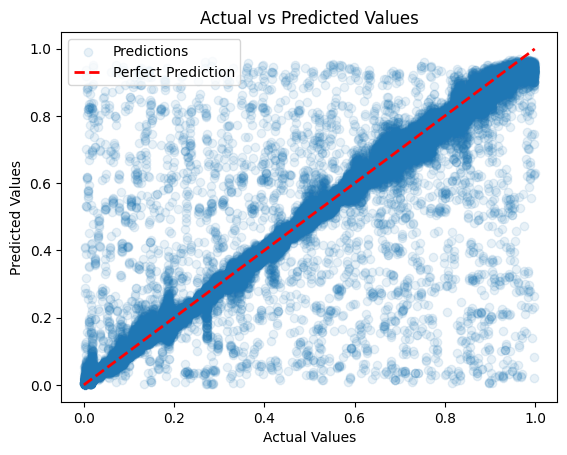

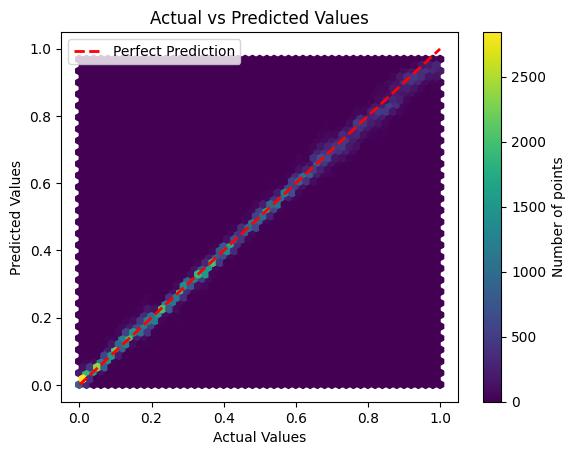

In [9]:

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared Score: {r2}')

#epsilon = 1e-15  # A very small number
#mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
#print(f'Mean Absolute Percentage Error: {mape}%')

medae = np.median(np.abs(y_test - y_pred))
print(f'Median Absolute Error: {medae}')

plt.scatter(y_test, y_pred, label='Predictions', alpha=0.1)

#hb = plt.hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
#plt.colorbar(hb, label='Number of points')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

# Add legend
plt.legend(loc='upper left')

# Ensure the axes are equal for a better visual comparison
#plt.axis('equal')

plt.show()


hb = plt.hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
plt.colorbar(hb, label='Number of points')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

# Add legend
plt.legend(loc='upper left')

# Ensure the axes are equal for a better visual comparison
#plt.axis('equal')

plt.show()